In [1]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

# Plotting
from matplotlib import pyplot as plt
import plotly

# Other
import os, sys
import time

import copy
import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
from noisyopt import minimizeSPSA
import optuna # Automatic tuning tool

import multiprocessing

import warnings
warnings.filterwarnings("ignore", message="For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.")

##############

# My functions:
sys.path.insert(0, '../')
import vqe_functions as vqe
import qcnn_functions as qcnn

In [2]:
N = 8

J = 1

In [3]:
device_jax = qml.device("default.qubit.jax", wires = N, shots = None)
device_mix = qml.device("default.mixed", wires = N, shots = None) 
device_def = qml.device("default.qubit", wires = N, shots = None)

# VQE

In [8]:
epochs = 60
prep_epochs = 25
first_prep_epoch = 250
l_steps = 100

# Default.mixed (multiprocessed) 
vqe_e, errs, thetas2, ys = vqe.train(0.02, epochs, N, J, l_steps, device_def, vqe.vqe_circuit, optimizer = 'adam',
                                    circuit = True, plots = True, prepare_states = False, preplots = True, pretrained = thetas,
                                    prep_step_size = 0.25, first_prep_epoch = first_prep_epoch, prep_epochs = prep_epochs, parameter_info = True)

+--- PARAMETERS ---+
step_size      = 0.025 (Step size of the optimizer)
prep_step_size = 0.005 (Step size in the preparing state phase)
n_epochs       = 1 (# epochs for the other GSs)
prep_epochs    = 25 (# epochs in the preparing state phase)
N              = 8 (Number of spins of the system)
cutoff_value   = 0.01 (Cuttoff Value in relative error to stop training)

+--- CIRCUIT ---+
0: ──RY(0.00)──RX(8.00)───||─╭C────────────────────||──RY(16.00)──RX(24.00)──||─╭C──────────────────
1: ──RY(1.00)──RX(9.00)───||─╰X─╭C─────────────────||──RY(17.00)──RX(25.00)──||─╰X─╭C───────────────
2: ──RY(2.00)──RX(10.00)──||────╰X─╭C──────────────||──RY(18.00)──RX(26.00)──||────╰X─╭C────────────
3: ──RY(3.00)──RX(11.00)──||───────╰X─╭C───────────||──RY(19.00)──RX(27.00)──||───────╰X─╭C─────────
4: ──RY(4.00)──RX(12.00)──||──────────╰X─╭C────────||──RY(20.00)──RX(28.00)──||──────────╰X─╭C──────
5: ──RY(5.00)──RX(13.00)──||─────────────╰X─╭C─────||──RY(21.00)──RX(29.00)──||─────────────╰X─╭C───
6: ──R

100%|█████████████████████████████████████████| 100/100 [02:54<00:00,  1.75s/it]


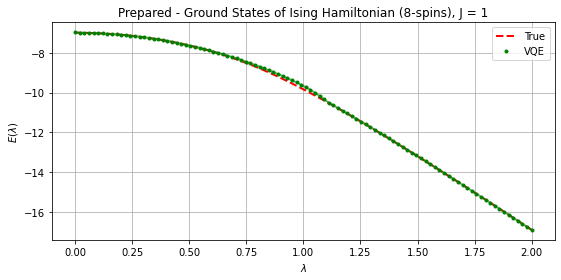

Cost: 0.0030581226674391416 | Active states: 13: 100%|█| 1/1 [00:01<00:00,  1.33


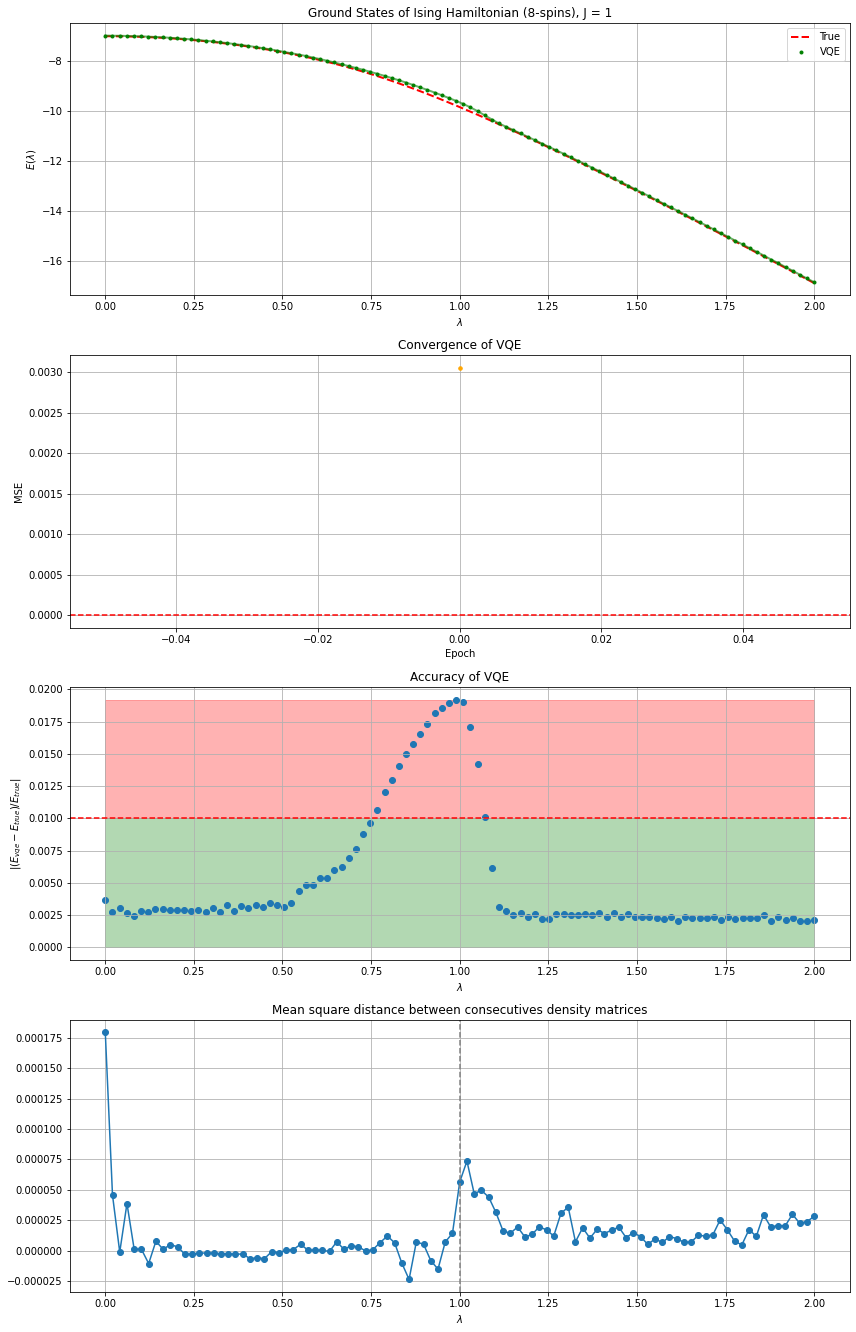

In [9]:
# Default.mixed (multiprocessed) 
vqe_e, errs, thetas, ys = vqe.train(0.025, 1, N, J, l_steps, device_def, vqe.vqe_circuit, optimizer = 'adam',
                                    circuit = True, plots = True, prepare_states = True, preplots = True,
                                    prep_step_size = 0.005, first_prep_epoch = first_prep_epoch, prep_epochs = prep_epochs, parameter_info = True)


In [12]:
vqe_data_x = thetas 
vqe_data_y = ys
    
vqe_data = []
for i in range(len(vqe_data_x)):
    vqe_data.append((vqe_data_x[i],vqe_data_y[i]))
    
vqe_data = np.array(vqe_data)

joblib.dump(vqe_data, '../vqe_states_job/0noiseN'+str(N)+'.job')

['../vqe_states_job/0noiseN8.job']

In [13]:
# Load data and separate in training and test set
data = joblib.load('../vqe_states_job/0noiseN'+str(N)+'.job')

train_index = np.sort(np.random.choice(np.arange(len(data)), size=int(0.8*len(data)), replace=False ))

X_train, Y_train = [], []
X_test, Y_test   = [], []

for i in range(len(data)): 
    if i in train_index:
        X_train.append(data[i][0])
        Y_train.append(data[i][1])
    else:
        X_test.append(data[i][0])
        Y_test.append(data[i][1])
        
#X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
#X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)


print('CLEAN DATA:')
print('______________________________')
print('Size of Data Set: {0}'.format(len(data)))
print('Size of Training Set: {0}'.format(np.shape(X_train)[0]))
print('Size of Test Set    : {0}'.format(np.shape(X_test)[0]))

CLEAN DATA:
______________________________
Size of Data Set: 100
Size of Training Set: 80
Size of Test Set    : 20


In [19]:
qcnn_circuit = qcnn.qcnn_circuit
vqe_circuit = vqe.vqe_circuit

In [27]:
# Noisy-less Circuit
def_start = time.time()
loss_history, accuracy_history, params = qcnn.train(100, 0.005, 0.0001, N, device_def, vqe_circuit, qcnn_circuit, 0, 0, 0, 0,
                                                  X_train, Y_train, X_test, Y_test, plot = False, info = True, batch_size = 0)
def_stop  = time.time()

+-- PARAMETERS ---+
a factor   = 0.005 ('a' coefficient of the optimizer)
r_shift    = 0.0001 (c coefficient of the optimizer)
epochs     = 100 (# epochs for learning)
N          = 8 (Number of spins of the system)
batch_size = 0 (batch size of the training process)


Cost: 40.5927 | Accuracy: 98.75: 100%|████████| 100/100 [03:07<00:00,  1.87s/it]


In [28]:
print(def_stop - def_start)

187.31845045089722


+-- PARAMETERS ---+
a factor   = 0.005 ('a' coefficient of the optimizer)
r_shift    = 0.0001 (c coefficient of the optimizer)
epochs     = 20 (# epochs for learning)
N          = 8 (Number of spins of the system)
batch_size = 32 (batch size of the training process)


100%|███████████████████████████████████████████| 20/20 [00:23<00:00,  1.18s/it]


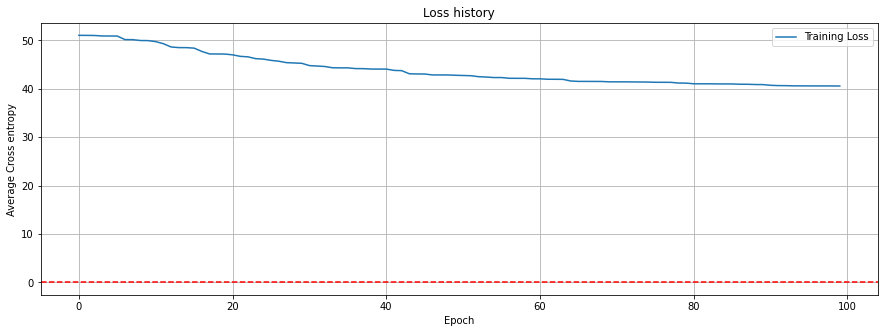

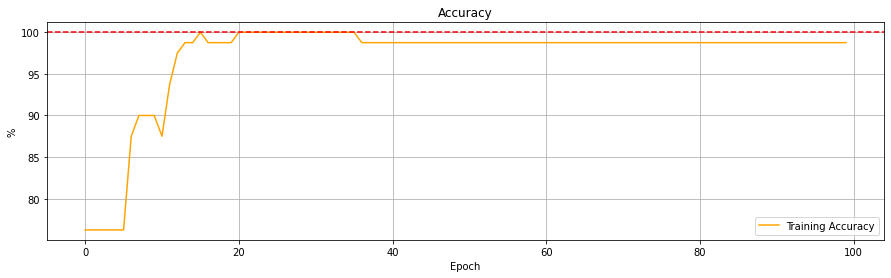

In [77]:
params = train_jax(20, 0.005, 0.0001, N, device_jax, vqe_circuit, qcnn_circuit, X_train, Y_train, X_test = [], Y_test = [], plot = True, info = True, batch_size = 32)

In [98]:
def compute_cross_entropy(X, Y, params):
    v_qcnn_prob = jax.vmap(lambda v:  qcnn_circuit_prob(v, params, N) )

    predictions = v_qcnn_prob(X)
    logprobs = jnp.log(predictions)

    nll = jnp.take_along_axis(logprobs, jnp.expand_dims(Y, axis=1), axis=1)
    ce = -jnp.mean(nll)

    return ce

In [99]:
compute_cross_entropy(X_train, Y_train, [0]*80)

DeviceArray(3.0675142, dtype=float32)

In [109]:
# Training function
def train_jax(epochs, lr, N, device, vqe_circuit_fun, qcnn_circuit_fun, X_train, Y_train, X_test = [], Y_test = [], plot = True, info = True, batch_size = 32):
    
    X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
    X_test, Y_test = jnp.array(X_test), jnp.array(Y_test)
    
    @qml.qnode(device, interface="jax")
    def qcnn_circuit_prob(params_vqe, params, N):
        qcnn_circuit_fun(params_vqe, vqe_circuit_fun, params, N)
    
        return qml.probs(wires = N - 1)
    
    
    def compute_cross_entropy(X, Y, params):
        v_qcnn_prob = jax.vmap(lambda v:  qcnn_circuit_prob(v, params, N) )

        predictions = v_qcnn_prob(X)
        logprobs = jnp.log(predictions)

        nll = jnp.take_along_axis(logprobs, jnp.expand_dims(Y, axis=1), axis=1)
        ce = -jnp.mean(nll)
        
        return ce
    
    if info:
        print('+-- PARAMETERS ---+')
        print('a factor   = {0} (\'a\' coefficient of the optimizer)'.format(lr) )
        print('epochs     = {0} (# epochs for learning)'.format(epochs) )
        print('N          = {0} (Number of spins of the system)'.format(N) )
        print('batch_size = {0} (batch size of the training process)'.format(batch_size) )
    
    # Initialize parameters
    n_params = qcnn_circuit_fun([0]*1000, vqe_circuit_fun, [0]*1000, N)
    params = np.array([np.pi/4]*n_params)
    
    # Cost function to minimize, returning the cross-entropy of the training set
    # Additionally it computes the accuracy of the training and test set 
    # (every 10 epochs)
    progress = tqdm.tqdm(range(epochs), position=0, leave=True)
    
    d_compute_cross_entropy = jax.jit( jax.grad(lambda p: compute_cross_entropy(X_train, Y_train, p) ) )
    
    for epoch in range(epochs):
        params -= lr*d_compute_cross_entropy(params)
        
        progress.update(1)
    
    if plot:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(len(loss_history)), np.asarray(loss_history), label = 'Training Loss')
       #if len(X_test) > 0:
            #plt.plot(np.arange(steps), np.asarray(loss_history_test)/len(X_test), color = 'green', label = 'Test Loss')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Loss history')
        plt.ylabel('Average Cross entropy')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
        plt.figure(figsize=(15,4))
        plt.plot(np.arange(len(accuracy_history)), accuracy_history, color='orange', label = 'Training Accuracy')
        if len(X_test) > 0:
            plt.plot(np.arange(len(accuracy_history_test))*10, accuracy_history_test, color='violet', label = 'Test Accuracy')
        plt.axhline(y=100, color='r', linestyle='--')
        plt.title('Accuracy')
        plt.ylabel('%')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
    return params
    return loss_history, accuracy_history, params

+-- PARAMETERS ---+
a factor   = 0.05 ('a' coefficient of the optimizer)
epochs     = 100000 (# epochs for learning)
N          = 8 (Number of spins of the system)
batch_size = 32 (batch size of the training process)


100%|██████████████████████████████████| 100000/100000 [03:39<00:00, 454.69it/s]


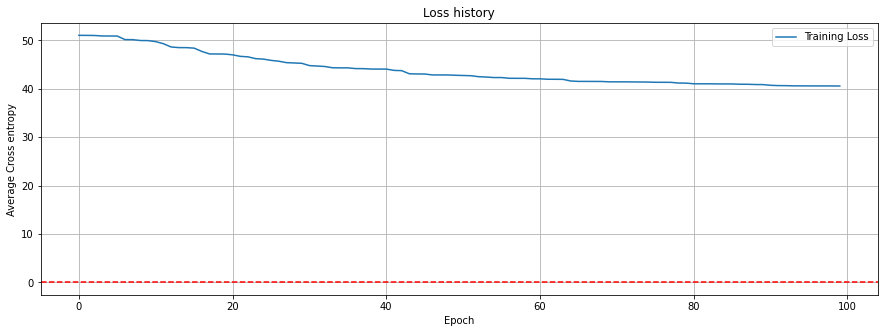

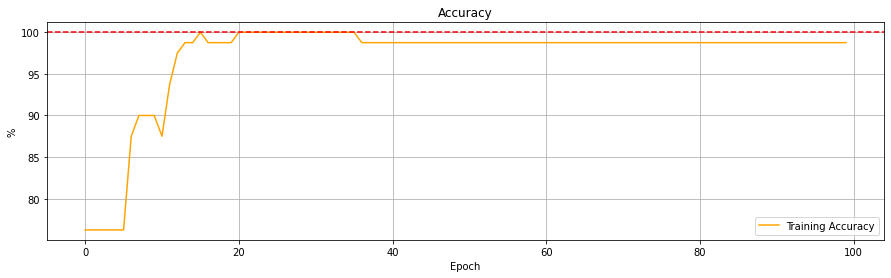

In [117]:
params = train_jax(100000, 0.05, N, device_jax, vqe_circuit, qcnn_circuit, X_train, Y_train, X_test = [], Y_test = [], plot = True, info = True, batch_size = 32)

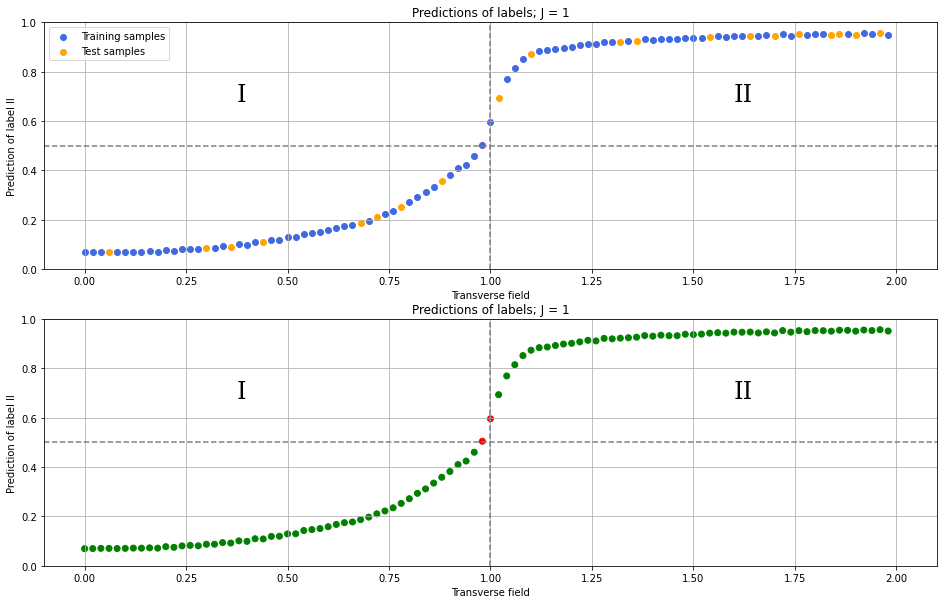

In [118]:
qcnn.plot_results_classification(data, train_index, params, N, device_jax, vqe_circuit, qcnn_circuit)